# <center>Report of practical part of Assignment 3</center>
# <center>IFT6135-H19</center>

**Team member**: 
- Qiang Ye (20139927)
- Ying Xiao (20111402)
- LiFeng Wan (20108546)
- Yunhe Li (20137167)

In [1]:
from os.path import exists
from google.colab import drive
import os
drive.mount('/content/dirve/', force_remount = True)
# change to your own directory
os.chdir("dirve/My Drive/Colab Notebooks/IFT6135/hw3/")
#!ls -al
from IPython.display import Image

Mounted at /content/dirve/


In [2]:
import numpy as np
import torch.nn as nn
import torch
import random
import math

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
print(cuda)

True


## Problem 1

### 1.0 Discriminator

In [0]:
class Discriminator(nn.Module):
    def __init__(self, input_dim = 2, hiddens = [32, 32]):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, hiddens[0]),
            #nn.BatchNorm1d(hiddens[0]),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(),
            nn.Linear(hiddens[0], hiddens[1]),
            #nn.BatchNorm1d(hiddens[1]),
            nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(),
            nn.Linear(hiddens[1], 1),
            #nn.Sigmoid(),
        )

    def forward(self, sample): # sample is sampling from a distribution
        validity = self.model(sample)
        return validity


### 1.1 Function estimating the Jensen Shannon Divergence

In [0]:
def estimate_JSD(real_p, fake_q, epsilon = 1e-12):
    """real_p, fake_q are outputs(with sigmoid) of a discriminator"""
    batch_size = real_p.size(0)
    real_p = real_p.view(batch_size, -1)
    fake_q = fake_q.view(batch_size, -1)
    JSD = 0.5 * (torch.log2(real_p + epsilon).mean())
    JSD = JSD + 0.5 * (torch.log2(1-fake_q + epsilon).mean())
    JSD = JSD + torch.log2(Tensor([2]))
    return JSD

### 1.2 Function estimating the Wasserstein Distance

In [0]:
def _compute_gp(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    batch_size = real_samples.size(0)
    alpha = np.random.random((batch_size, 1))
    alpha = Tensor(alpha)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates.requires_grad_(True)
    d_interpolates = D(interpolates)
    grad_outputs = Tensor(batch_size, 1).fill_(1.0)
    # Get gradient w.r.t. interpolates
    
    gradients = torch.autograd.grad(
        outputs = d_interpolates,
        inputs = interpolates,
        grad_outputs = grad_outputs,
        create_graph = True,
        retain_graph = True,
        only_inputs = True,
    )[0]
    gradients = gradients.view(batch_size, -1)
    #gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
    gradient_penalty = ((gradients.norm(2, dim = 1) - 1) ** 2).mean()
    return gradient_penalty


def estimate_WD(real_p, fake_q):
    """real_p, fake_q are outputs of a discriminator(no sigmoid)"""
    real_p = real_p.view(batch_size, -1)
    fake_q = fake_q.view(batch_size, -1)
    return torch.mean(real_p) - torch.mean(fake_q)

### 1.3 Train Discriminator and Plot Curves

#### 1.3.1 Method for training

In [0]:
# Training method
def train_discriminator(discriminator,  
                        dataset,       # dataset
                        theta,          # to certain distribution
                        estimate_metrics = estimate_JSD, # JSD or WD
                        max_epoch = 100, 
                        batch_in_epoch = 100,    # number of batches in an epoch
                        epoch_patience = 10,     # early stop patience
                        batch_size = 512
                       ):

    optimizer = torch.optim.SGD(discriminator.parameters(), lr=1e-3)
    min_val_loss = float('inf')    # minimal average loss of an epoch
    best_param_dict = discriminator.state_dict()  # best model parameters
    early_stop_delay = 0 
    best_JSD_WD = None   # best JSD or WD during training.
    train_p, train_q, val_p, val_q = dataset
    n_batch = train_p.size(0) // batch_size
    for epoch in range(max_epoch):
        avg_train_loss, avg_train_JSD_WD = 0, 0
        for i in range(n_batch):
            samples_p = train_p[i: i+batch_size,:]
            samples_q = train_q[i:i+batch_size,:]
            real_p_validity = discriminator(samples_p)
            fake_q_validity = discriminator(samples_q)
            
            if estimate_metrics is estimate_JSD:
                # JSD compute loss using data within [0,1], WD doesn't.
                real_p_validity = torch.sigmoid(real_p_validity)
                fake_q_validity = torch.sigmoid(fake_q_validity)
            
            # value of Jensen-Shannon Divergence or Wasserstein distance
            JSD_WD = estimate_metrics(real_p_validity, fake_q_validity)
            d_loss = -1 * JSD_WD
            
            if estimate_metrics is estimate_WD: 
                # Wasserstein need gradient penalty
                grad_penalty = _compute_gp(discriminator, samples_p, samples_q)
                d_loss += lambda_gp * grad_penalty
            
            optimizer.zero_grad()
            d_loss.backward()
            optimizer.step()
        
            cur_loss = d_loss.item()
            cur_JSD_WD = JSD_WD.item()
            
            avg_train_loss += cur_loss        # accumulate in one epoch
            avg_train_JSD_WD += cur_JSD_WD
        
        avg_train_loss /= n_batch     # average loss in one eopch
        avg_train_JSD_WD /= n_batch
        
        val_real_p = discriminator(val_p)
        val_fake_q = discriminator(val_q)
        
        if metrics_name == "JSD": # JSD using data in [0,1]
            val_real_p = torch.sigmoid(val_real_p)
            val_fake_q = torch.sigmoid(val_fake_q)
        
        # performance on val dataset
        val_JSD_WD = metrics(val_real_p, val_fake_q).data.item()
        val_loss = -1 * val_JSD_WD
        if estimate_metrics is estimate_WD: 
            # Wasserstein need gradient penalty
            grad_penalty = _compute_gp(discriminator, samples_p, samples_q)
            val_loss += lambda_gp * grad_penalty
        
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            early_stop_delay = 0
            best_JSD_WD = val_JSD_WD
            best_param_dict = discriminator.state_dict()
        else:
            early_stop_delay += 1
            if early_stop_delay >= epoch_patience:
                discriminator.load_state_dict(best_param_dict)
                print('early stop')
                return best_JSD_WD
        
        if epoch % 10 == 0:  
            print("[Epoch {:3}/{:3} Batch {:2}/{} train_loss:{} val_loss: {}".format(
                    1+epoch, max_epoch, i+1, n_batch, avg_train_loss, val_loss)
                ,end = " ")
            if early_stop_delay == 0:
                print("*")
            else:
                print("")

    discriminator.load_state_dict(best_param_dict)
    return best_JSD_WD

#### 1.3.2 Training on distributions (0, Z) and ($\phi$, Z) where $\phi \in [-1,1]$, $Z\in \mathbf U(0,1)$

In [30]:
from samplers import distribution1
input_dim = 2
batch_size = 512
lambda_gp = 10 # lambda for gradient penalty

torch.manual_seed(0)
batch_size = 512
train_size, val_size = batch_size * 100, 5000

torch.manual_seed(0)

metrics_names = ["JSD", "WD"]
estimates = {"JSD":[], "WD":[]}

train_p = Tensor(next(distribution1(0, train_size)))
val_p = Tensor(next(distribution1(0, val_size)))

for theta in np.arange(-1, 1.1, 0.1):
    
    train_q = Tensor(next(distribution1(theta, train_size)))
    val_q = Tensor(next(distribution1(theta, val_size)))
    data_set = (train_p, train_q, val_p, val_q)
    
    for metrics_name in metrics_names:
        torch.manual_seed(1)
        discriminator = Discriminator(input_dim = 2, hiddens = [32, 32])
        if cuda:
            discriminator.cuda()
            
        metrics = estimate_JSD if metrics_name == "JSD" else estimate_WD
        # different early stop patience
        patience = 10 # if metrics_name == "JSD" else 10
        max_epoch = 1000 if metrics_name == "JSD" and -0.31< theta < 0.31 else 500
        
        # training a discriminator
        JSD_WD = train_discriminator(discriminator,
                            data_set,
                            theta, 
                            estimate_metrics = metrics,
                            max_epoch = max_epoch, 
                            epoch_patience = patience)
        
        print(metrics_name, "theta:", theta, "score:", JSD_WD)
        print()
        estimates[metrics_name].append(JSD_WD)

[Epoch   1/500 Batch 100/100 train_loss:-0.014006394743919372 val_loss: -0.019347012042999268 *
[Epoch  11/500 Batch 100/100 train_loss:-0.1425907015800476 val_loss: -0.15057283639907837 *
[Epoch  21/500 Batch 100/100 train_loss:-0.3426902735233307 val_loss: -0.3547099232673645 *
[Epoch  31/500 Batch 100/100 train_loss:-0.5823838669061661 val_loss: -0.5936436653137207 *
[Epoch  41/500 Batch 100/100 train_loss:-0.7630802464485168 val_loss: -0.770017147064209 *
[Epoch  51/500 Batch 100/100 train_loss:-0.8643922543525696 val_loss: -0.8680166602134705 *
[Epoch  61/500 Batch 100/100 train_loss:-0.9163678562641144 val_loss: -0.9182463884353638 *
[Epoch  71/500 Batch 100/100 train_loss:-0.9437568736076355 val_loss: -0.9448087811470032 *
[Epoch  81/500 Batch 100/100 train_loss:-0.9594329816102981 val_loss: -0.9600766897201538 *
[Epoch  91/500 Batch 100/100 train_loss:-0.9691452020406723 val_loss: -0.9695684909820557 *
[Epoch 101/500 Batch 100/100 train_loss:-0.9755636614561081 val_loss: -0.975

#### 1.3.3 Plot curves

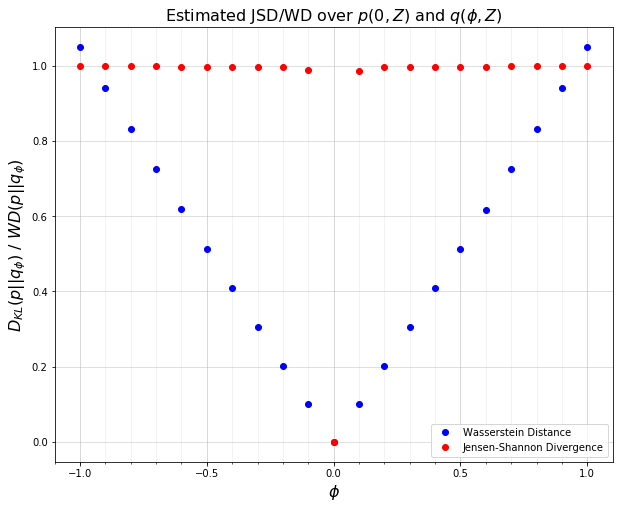

In [38]:
import matplotlib.pyplot as plt
# plot p0 and p1
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(-1.0, 1.1, 0.5)
minor_ticks = np.arange(-1.1, 1.1, 0.1)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

# empirical
thetas = np.arange(-1, 1.1, 0.1)
plt.plot(thetas, estimates["WD"], "ob", label = "Wasserstein Distance")
plt.plot(thetas, estimates["JSD"], "or", label = "Jensen-Shannon Divergence")

plt.legend(loc = "lower right")
plt.title(r"Estimated JSD/WD over $p(0, Z)$ and $q(\phi, Z)$", fontsize = 16)
plt.xlabel(r'$\phi$', fontsize = 16)
plt.ylabel(r'$D_{KL}(p||q_{\phi})\ /\ WD(p||q_{\phi})$', fontsize = 16)
plt.show()
fig.savefig("problem1_3.png")

### 1.4 See problem1_4.ipynb